Déroulement du [tuto](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5) Detectron2

# Paramétrage

## Librairies

In [ ]:
# partie spécifique Google Colab
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-tcvp6x8z
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-tcvp6x8z
  Resolved https://github.com/facebookresearch/detectron2.git to commit e9f7e2ba15abd7badcb05ef6f5076f06b36a9c5b
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=6119646 sha256=3a9b3d334221ea4d06e03e3aed58be

In [ ]:
# partie spécifique Google Colab
!python -m pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 64.8 MB/s eta 0:00:00


In [ ]:
import torch
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import pandas as pd
import os, json, cv2, random
from google.colab.patches import cv2_imshow
from google.colab import drive
import geopandas as gpd
import rasterio
import shapely
import tqdm
from datetime import date

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

import tensorflow as tf


## Données

In [ ]:
# partie spécifique Google Colab
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# partie spécifique Google Colab
!mkdir -p /content/data/decoupe_final
!cp /content/drive/MyDrive/data/DST/df_decoupe_final.csv /content/data/decoupe_final/df_decoupe_final.csv
!unzip /content/drive/MyDrive/data/DST/decoupe_final.zip -d /content/data/decoupe_final

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
 extracting: /content/data/decoupe_final/decoupe_final/69-2020_8_834400.0_22_6508200.0_33.cpg  
  inflating: /content/data/decoupe_final/decoupe_final/69-2020_8_834400.0_22_6508200.0_33.dbf  
  inflating: /content/data/decoupe_final/decoupe_final/69-2020_8_834400.0_22_6508200.0_33.jp2  
  inflating: /content/data/decoupe_final/decoupe_final/69-2020_8_834400.0_22_6508200.0_33.prj  
  inflating: /content/data/decoupe_final/decoupe_final/69-2020_8_834400.0_22_6508200.0_33.shp  
  inflating: /content/data/decoupe_final/decoupe_final/69-2020_8_834400.0_22_6508200.0_33.shx  
 extracting: /content/data/decoupe_final/decoupe_final/69-2020_8_834400.0_22_6508200.0_33_data.jpg  
  inflating: /content/data/decoupe_final/decoupe_final/69-2020_8_834400.0_22_6508200.0_33_data.jpg.aux.xml  
  inflating: /content/data/decoupe_final/decoupe_final/69-2020_8_834400.0_22_6508200.0_33_label.png  
  inflating: /content/data/decoupe

In [ ]:
data_path = '/content/data/decoupe_final'
images_path = '/content/data/decoupe_final/decoupe_final'
df_decoupe = pd.read_csv(data_path + '/df_decoupe_final.csv')
df_decoupe.head()

dalle_X  dalle_Y         X          Y  X_size  Y_size  \
0        0        0  825000.0  6509800.0    1000    1000   
1        0        1  825000.0  6509600.0    1000    1000   
2        0        2  825000.0  6509400.0    1000    1000   
3        0        3  825000.0  6509200.0    1000    1000   
4        0        4  825000.0  6509000.0    1000    1000   

                          fichier_raster  \
0   69-2020_0_825000.0_0_6509800.0_0.jp2   
1   69-2020_1_825000.0_0_6509600.0_0.jp2   
2   69-2020_2_825000.0_0_6509400.0_4.jp2   
3   69-2020_3_825000.0_0_6509200.0_4.jp2   
4  69-2020_4_825000.0_0_6509000.0_19.jp2   

                                  fichier_img  \
0   69-2020_0_825000.0_0_6509800.0_0_data.jpg   
1   69-2020_1_825000.0_0_6509600.0_0_data.jpg   
2   69-2020_2_825000.0_0_6509400.0_4_data.jpg   
3   69-2020_3_825000.0_0_6509200.0_4_data.jpg   
4  69-2020_4_825000.0_0_6509000.0_19_data.jpg   

                                  fichier_mask  \
0   69-2020_0_825000.0_0_6509800.0_0_label.png   
1   69-2020_1_825000.0_0_6509600.0_0_label.png   
2   69-2020_2_825000.0_0_6509400.0_4_label.png   
3   69-2020_3_825000.0_0_6509200.0_4_label.png   
4  69-2020_4_825000.0_0_6509000.0_19_label.png   

                          fichier_shapes  formes  multi  erreur  
0   69-2020_0_825000.0_0_6509800.0_0.shp       0      0       0  
1   69-2020_1_825000.0_0_6509600.0_0.shp       0      0       0  
2   69-2020_2_825000.0_0_6509400.0_4.shp       4      0       0  
3   69-2020_3_825000.0_0_6509200.0_4.shp       4      0       0  
4  69-2020_4_825000.0_0_6509000.0_19.shp      19      0       0

# Test d'un modèle Detectron2 pré-entraîné

In [ ]:
n_image = np.random.randint(df_decoupe.shape[0])
image = cv2.imread(images_path + '/' + df_decoupe['fichier_img'].values[n_image])

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
# uniquement si l'on ne travaille pas avec un GPU
# cfg.MODEL.DEVICE = 'cpu'
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(image)

[01/04 11:33:18 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


model_final_f10217.pkl: 178MB [00:02, 83.0MB/s]                          
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


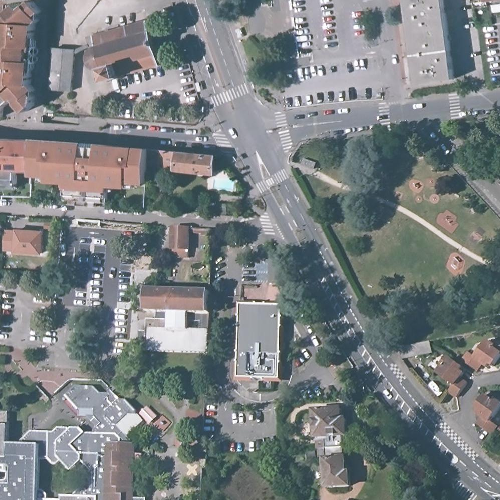

In [ ]:
v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.5)
out = v.draw_instance_predictions(outputs['instances'].to('cpu'))
cv2_imshow(out.get_image()[:, :, ::-1])

# Entraînement d'un modèle Detectron2

## Pre-processing

In [ ]:
def get_detectron2_dict(df_decoupe, images_path, bbox_mode = BoxMode.XYXY_ABS):
  '''
  fonction qui prépare les données pour Detectron2
  un dict est généré selon le format spécifié dans la documentation, voir https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html#standard-dataset-dicts
  '''
  dataset_dict = []
  for i_image in tqdm.tqdm(range(df_decoupe.shape[0])):
    # parcours de toutes les images
    record = {}
    # nom et id de l'image
    filename = images_path + '/' + df_decoupe['fichier_img'].values[i_image]
    record['file_name'] = filename
    record['image_id'] = i_image

    # lecture du fichier image pour avoir la taille
    image = cv2.imread(filename)
    record['width'] = image.shape[0]
    record['height'] = image.shape[1]

    # lecture des données Shapefile pour les coordonnées des formes
    shp = gpd.read_file(images_path + '/' + df_decoupe['fichier_shapes'].values[i_image])
    shp = shp.explode(index_parts = False)

    # lectude du fichier raster pour convertir les coordonnées des formes en positions pixels
    with rasterio.open(images_path + '/' + df_decoupe['fichier_raster'].values[i_image]) as raster:
      # création du convertisseur pour passer des coordonnées en pixels
      raster_transform = raster.transform
      raster_transformer = rasterio.transform.AffineTransformer(raster_transform)
      objs = []
      # parcours de toutes les formes de l'image
      for i_forme, shape in enumerate(shp['geometry']):
        # on récupère les coordonnées des contours
        xy = shapely.get_coordinates(shape)
        # on tranforme en pixels
        row_cols = raster_transformer.rowcol(xy[:,0], xy[:,1])
        # on mémorise les pixels de contour
        # /!\ il faut inverser x et y
        px = row_cols[1]
        py = row_cols[0]
        # on liste à la suite tous les x et y, en prenant une petite marge
        poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
        poly = [p for coord in poly for p in coord]
        obj = {
            # pour le bord, on prend le min et max des coordonnées
            'bbox': [np.min(px), np.min(py), np.max(px), np.max(py)],
            'bbox_mode': bbox_mode,
            'segmentation': [poly],
            # une seule catégorie : bâtiment
            'category_id': 0}
        objs.append(obj)
      record['annotations'] = objs
    dataset_dict.append(record)
  return dataset_dict

In [ ]:
def load_img(input_img_path, img_size = None):
  '''
  fonction qui renvoie un tensor 3x3, avec sur chaque ligne :
  - le nombre de pixels de l'image (2 derniers éléments à nan)
  - la moyenne par canal
  - la somme des carrés par canal
  '''
  input_img = tf.io.read_file(input_img_path)
  input_img = tf.io.decode_png(input_img, channels = 3)
  if img_size is not None:
    input_img = tf.image.resize(input_img, img_size)
  input_img = tf.cast(input_img, 'float64')
  pixel_sum = tf.reduce_sum(input_img, axis = [0, 1])
  pixel_sum_sq = tf.reduce_sum(tf.math.pow(input_img, 2), axis = [0, 1])
  nb_pixels = tf.reshape(tf.cast(tf.size(input_img[:,:,0]), 'float64'), [1])
  nb_pixels = tf.concat([nb_pixels, tf.cast(tf.constant([np.nan, np.nan]), 'float64')], 0)
  return tf.stack([nb_pixels, pixel_sum, pixel_sum_sq])



Calcul des moyennes et std par canal

In [ ]:
input_img_paths = images_path + '/' + df_decoupe['fichier_img'].values
batch_size = 1

dataset = tf.data.Dataset.from_tensor_slices(input_img_paths)
dataset = dataset.map(load_img, num_parallel_calls = tf.data.AUTOTUNE)
dataset_batch = dataset.batch(batch_size)

dataset_batch_sum = dataset_batch.reduce(np.float64(0), tf.math.add)
dataset_batch_nb = dataset_batch_sum[0][0, 0].numpy()
dataset_batch_mean = dataset_batch_sum[0][1,:].numpy()/dataset_batch_nb
dataset_batch_sum_sq = dataset_batch_sum[0][2,:].numpy()
print('RGB moyen {}'.format(dataset_batch_mean))
print('RGB std {}'.format(np.sqrt(dataset_batch_sum_sq/dataset_batch_nb - dataset_batch_mean**2)))

RGB moyen [ 99.09907408 107.76452994 100.53441005]
RGB std [46.13069801 36.72978612 37.35769952]


Création des données

In [ ]:
df_train, df_test = train_test_split(df_decoupe, test_size=0.2, random_state = 77)
df_dict = {
    'train' : df_train,
    'val' : df_test
}
for phase in ['train', 'val']:
  # ne pas exécuter si le dataset est déjà enregistré
  DatasetCatalog.register('images_bati_' + phase, lambda phase=phase: get_detectron2_dict(df_dict[phase], images_path))
  MetadataCatalog.get('images_bati_' + phase).set(thing_classes = ['batiment'])

Affichage d'un exemple d'affichage pour vérifier que la création des données s'est bien déroulée

In [ ]:
dataset_dict_train = get_detectron2_dict(df_dict['train'], images_path)

100%|██████████| 6000/6000 [06:23<00:00, 15.63it/s]


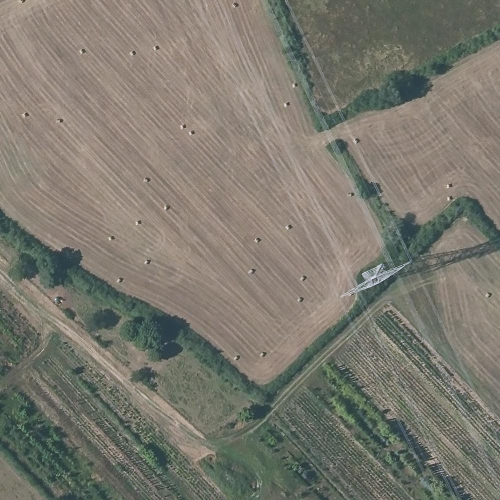

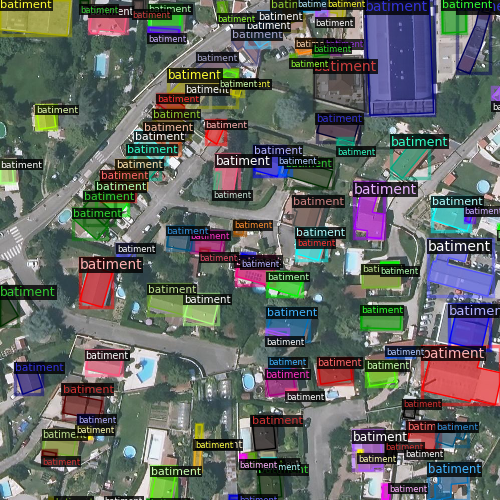

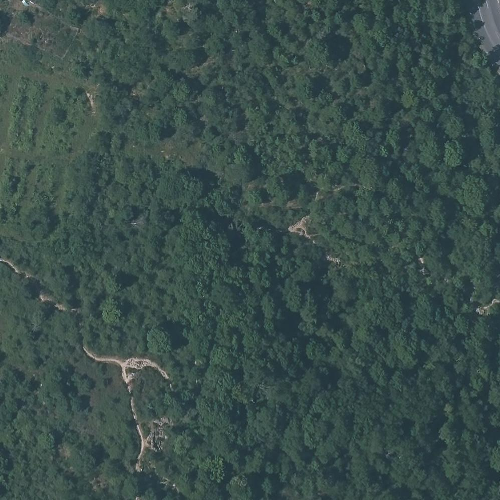

In [ ]:
images_metadata_train = MetadataCatalog.get('images_bati_train')
for record in random.sample(dataset_dict_train, 3):
  # openCV fonctionne en BGR
  img = cv2.imread(record['file_name'])
  visualizer = Visualizer(img[:, :, ::-1], metadata = images_metadata_train, scale=0.5)
  out = visualizer.draw_dataset_dict(record)
  cv2_imshow(out.get_image()[:, :, ::-1])
  print('')

## Entraînement

Voir la documentation pour :

+ [mettre à jour](https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html#update-the-config-for-new-datasets) la configuration des modèles pour traiter les données customisées
+ le [format](https://detectron2.readthedocs.io/en/latest/tutorials/models.html#model-output-format) des données de prédiction
+ la [liste](https://detectron2.readthedocs.io/en/latest/modules/config.html#yaml-config-references) des données de configuration (ou sinon faire *print(get_cfg())*)

Voir la [liste](https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md) des modèles disponibles

**Explication des métriques :**

+ total_loss: This is a weighted sum of the following individual losses calculated during the iteration. By default, the weights are all one.
+ loss_cls: Classification loss in the ROI head. Measures the loss for box classification, i.e., how good the model is at labelling a predicted box with the correct class.
+ loss_box_reg: Localisation loss in the ROI head. Measures the loss for box localisation (predicted location vs true location).
+ loss_rpn_cls: Classification loss in the Region Proposal Network. Measures the "objectness" loss, i.e., how good the RPN is at labelling the anchor boxes as foreground or background.
+ loss_rpn_loc: Localisation loss in the Region Proposal Network. Measures the loss for localisation of the predicted regions in the RPN.
+ loss_mask: Mask loss in the Mask head. Measures how "correct" the predicted binary masks are.
+ time: Time taken by the iteration.
+ data_time: Time taken by the dataloader in that iteration.
+ lr: The learning rate in that iteration.
+ max_mem: Maximum GPU memory occupied by tensors in bytes.

In [ ]:
%env PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512
# , backend:cudaMallocAsync

env: PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512


In [ ]:
from detectron2.engine import DefaultTrainer

today_date = date.today().strftime('%Y%m%d')
model_config_file = 'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'
dataset_train = 'images_bati_train'

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(model_config_file))
cfg.DATASETS.TRAIN = (dataset_train)
cfg.DATASETS.TEST = ()
cfg.OUTPUT_DIR = '/content/drive/MyDrive/DataScientest/Detectron2/mask_rcnn_R_50_FPN_3x_' + today_date
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_config_file)
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 50000
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(MetadataCatalog.get(dataset_train).thing_classes)
cfg.TEST.DETECTIONS_PER_IMAGE = 200
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[8, 16, 32, 64, 128, 256]]
cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.5, 1.0, 2.0]]
cfg.INPUT.FORMAT = 'BGR'
cfg.MODEL.PIXEL_MEAN = [100.534, 107.764, 99.099]
cfg.MODEL.PIXEL_STD = [37.358, 36.780, 46.131]

os.makedirs(cfg.OUTPUT_DIR, exist_ok = True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[01/07 08:46:29 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

100%|██████████| 6000/6000 [05:55<00:00, 16.90it/s]

[01/07 08:52:24 d2.data.build]: Removed 1380 images with no usable annotations. 4620 images left.


[01/07 08:52:24 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  batiment  | 124833       |
|            |              |
[01/07 08:52:24 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[01/07 08:52:24 d2.data.build]: Using training sampler TrainingSampler
[01/07 08:52:24 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[01/07 08:52:24 d2.data.common]: Serializing 4620 elements to byte tensors and concatenating them all ...
[01/07 08:52:25 d2.data.common]: Serialized dataset takes 32.83 MiB
[01/07 08:52:25 d2.data.build]: Making batched data loader with batch_size=8
[01/07 08:52:26 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceS

model_final_f10217.pkl: 178MB [00:00, 197MB/s]                           
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[01/07 08:52:27 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[01/07 08:53:11 d2.utils.events]:  eta: 1 day, 3:57:34  iter: 19  total_loss: 2.896  loss_cls: 1.024  loss_box_reg: 0.0497  loss_mask: 0.6933  loss_rpn_cls: 0.6912  loss_rpn_loc: 0.4286    time: 2.0444  last_time: 1.7871  data_time: 0.1313  last_data_time: 0.1046   lr: 4.9953e-06  max_mem: 7154M
[01/07 08:53:51 d2.utils.events]:  eta: 1 day, 3:38:54  iter: 39  total_loss: 2.408  loss_cls: 0.5306  loss_box_reg: 0.04517  loss_mask: 0.6903  loss_rpn_cls: 0.6863  loss_rpn_loc: 0.4242    time: 2.0189  last_time: 1.9199  data_time: 0.1187  last_data_time: 0.1151   lr: 9.9902e-06  max_mem: 7154M
[01/07 08:54:33 d2.utils.events]:  eta: 1 day, 4:13:12  iter: 59  total_loss: 2.086  loss_cls: 0.2698  loss_box_reg: 0.05167  loss_mask: 0.6854  loss_rpn_cls: 0.6804  loss_rpn_loc: 0.3741    time: 2.0435  last_time: 2.2030  data_time: 0.1193  last_data_time: 0.1204   lr: 1.4985e-05  max_mem: 7527M
[01/07 08:55:17 d2.utils.events]:  eta: 1 day, 4:40:25  iter: 79  total_loss: 2.034  loss_cls: 0.2387  lo

OSError: [Errno 107] Transport endpoint is not connected

## Evaluation

In [ ]:
dataset_dict_val = get_detectron2_dict(df_dict['val'], images_path)


100%|██████████| 1500/1500 [01:41<00:00, 14.84it/s]


In [ ]:
dataset_val = 'images_bati_val'
model_config_file = 'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(model_config_file))
# uniquement si l'on ne travaille pas avec un GPU
# cfg.MODEL.DEVICE = 'cpu'
cfg.MODEL.WEIGHTS = os.path.join('/content/drive/MyDrive/DataScientest/Detectron2/mask_rcnn_R_50_FPN_3x_20240104/model_final.pth')
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(MetadataCatalog.get(dataset_val).thing_classes)
confidence_threshold = 0.5
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = confidence_threshold
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = confidence_threshold
cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = confidence_threshold
predictor = DefaultPredictor(cfg)


[01/04 19:20:01 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/DataScientest/Detectron2/mask_rcnn_R_50_FPN_3x_20240104/model_final.pth ...


proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}


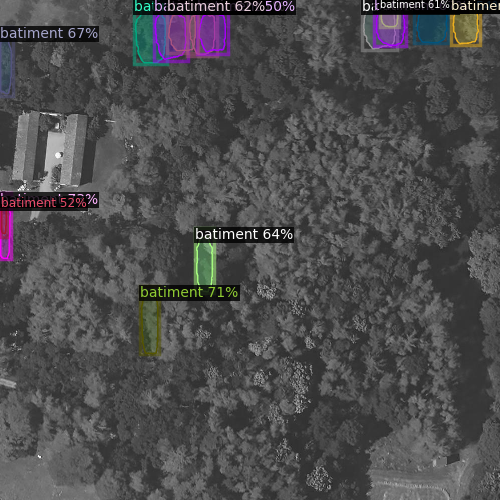

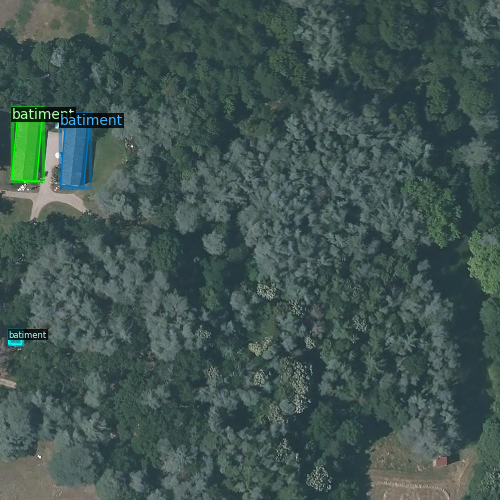

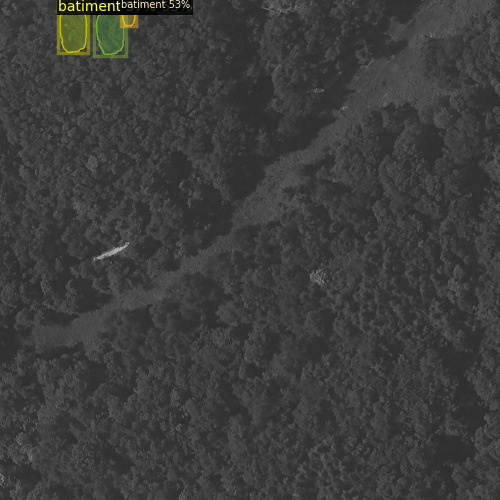

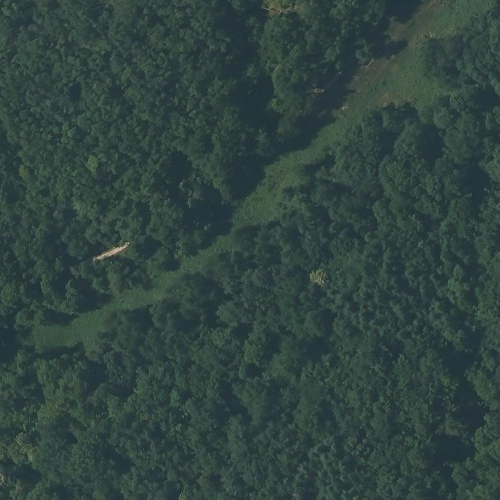

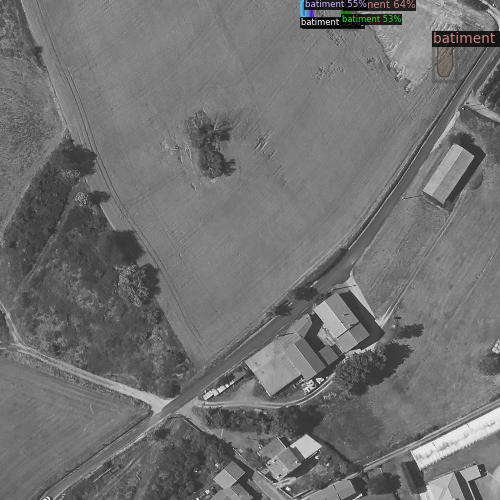

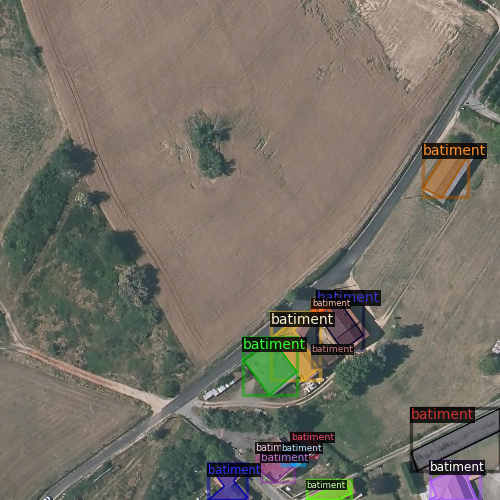

In [ ]:
images_metadata_val = MetadataCatalog.get(dataset_val)
for record in random.sample(dataset_dict_val, 3):
  img = cv2.imread(record['file_name'])
  outputs = predictor(img)
  # openCV fonctionne en BGR
  visualizer = Visualizer(img[:, :, ::-1],
                          metadata = images_metadata_val,
                          scale=0.5,
                          instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
                          )
  out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
  visualizer2 = Visualizer(img[:, :, ::-1], metadata = images_metadata_val, scale=0.5)
  out2 = visualizer2.draw_dataset_dict(record)
  cv2_imshow(out.get_image()[:, :, ::-1])
  print('')
  cv2_imshow(out2.get_image()[:, :, ::-1])
  print('')


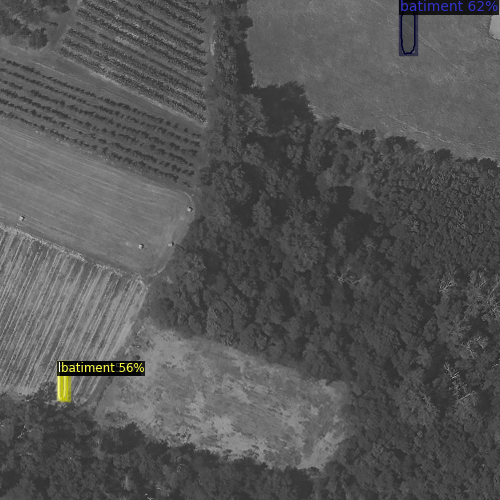

3 formes détectées pour 0 formes labellisées



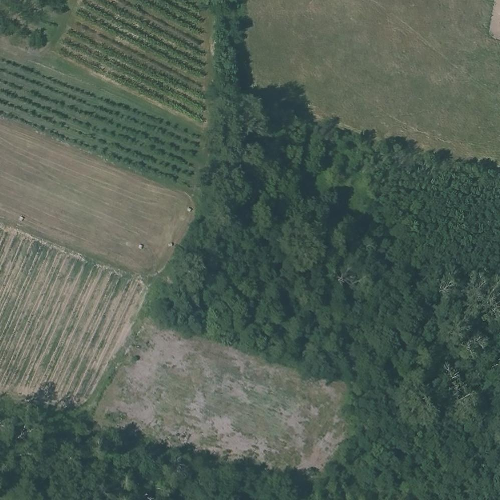

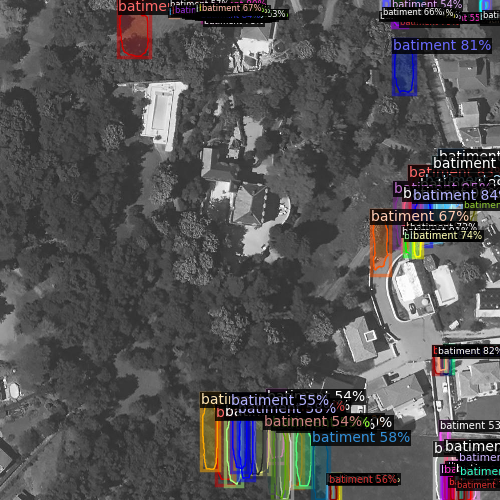

100 formes détectées pour 29 formes labellisées



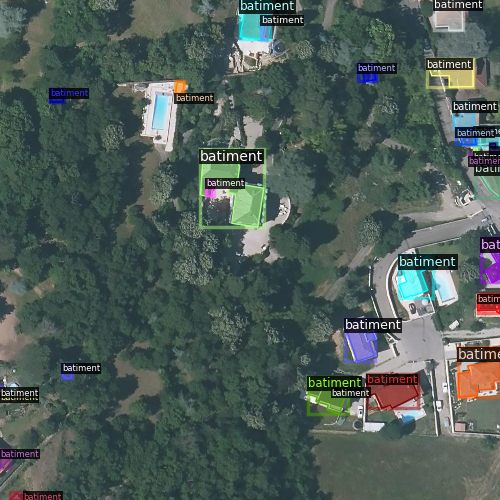

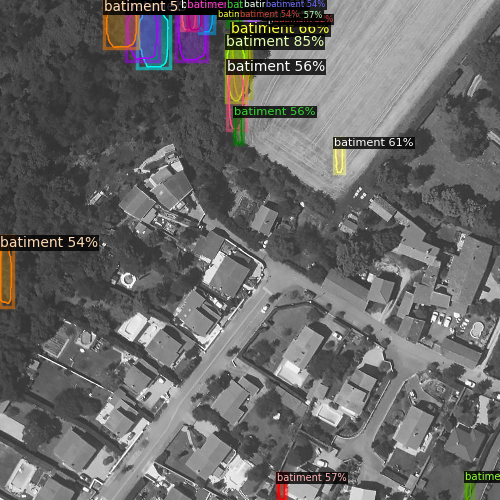

25 formes détectées pour 66 formes labellisées



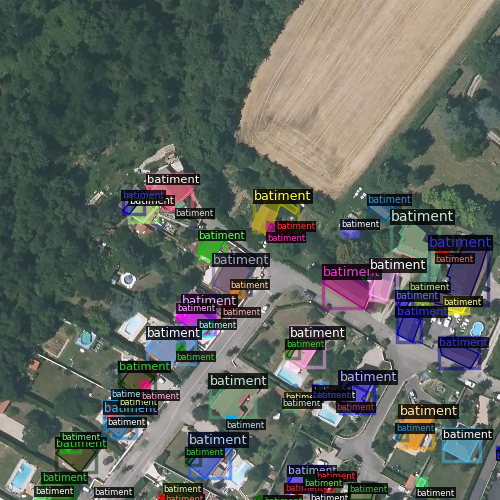

In [ ]:
images_metadata_train = MetadataCatalog.get('images_bati_train')
for record in random.sample(dataset_dict_train, 3):
  img = cv2.imread(record['file_name'])
  outputs = predictor(img)
  visualizer = Visualizer(img[:, :, ::-1],
                          metadata = images_metadata_train,
                          scale=0.5,
                          instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
                          )
  out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
  visualizer2 = Visualizer(img[:, :, ::-1], metadata = images_metadata_val, scale=0.5)
  out2 = visualizer2.draw_dataset_dict(record)
  cv2_imshow(out.get_image()[:, :, ::-1])
  print('{} formes détectées pour {} formes labellisées'.format(len(outputs["instances"]), len(record["annotations"])))
  print('')
  cv2_imshow(out2.get_image()[:, :, ::-1])
  print('')

